## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

In [2]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
import warnings, datetime
import scipy.stats as ss

## Algorithm 1 - Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [5]:
# Extracts non-occupied keys for a given sequence
def extract_non_occupied_keys(keyset):
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset:
            non_occupied_keys.append(i)
        
    return non_occupied_keys

# Groups a list of keys into subsequences of consecutive keys 
def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

# Extract the endpoints of each subsequence
def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0])
            endpoints.append(sequence[len(sequence)-1])
            
    return endpoints

# Partition the non-occupied keys, i.e., keys not in K ∪ P, into subsequences such that each subsequence consists of consecutive non-occupied keys;
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    return np.array(endpoints)

# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        rank = list(ss.rankdata(keyset_extended))
        # extract rank for the last element in the list (endpoint)
        computed_rank_for_endpoint.append(int(rank[len(rank)-1]))
    
    return computed_rank_for_endpoint
    

In [6]:
import operator
from statistics import mean

def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys p
    P = p * n
    poisoning_keys = set()
    

    for j in range(int(P)):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        endpoints = partition_non_occupied_keys(keyset, poisoning_keys)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        list_rank = compute_rank_for_endpoints(endpoints, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;
        S = endpoints
        T = list_rank
        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(rankset)

        M_K_square[0] = np.mean(keyset**2)

        M_R_square[0] = np.mean(rankset**2)

        M_KR[0] = np.mean(keyset*rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(endpoints)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [7]:
df=pd.read_csv('../data/random_2000.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])
regressor_legitimate = LinearRegression()
regressor_legitimate.fit(X, y) 

y_pred = regressor_legitimate.predict(X)
mse_legitimate = metrics.mean_squared_error(y, y_pred)

In [8]:
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  

Mean Squared Error: 22.990043047393875


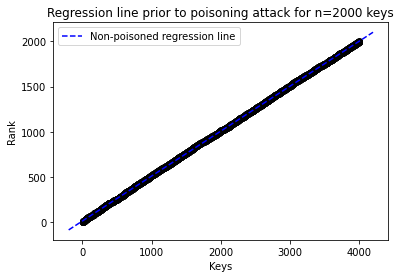

In [9]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

# Plot outputs
plt.scatter(X, y,  color='black')
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
label= "Regression line prior to poisoning attack for n=2000 keys"
plt.title(label=label)
plt.show()

## Linear regression with poisoned keys

In [1]:
#cProfile.run('obtain_poisoning_keys(p = 0.2, keyset=X, rankset=y)', sort = "time")

In [31]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=X, rankset=y)

In [32]:
df = pd.DataFrame(data=list(poisoning_keys))
df.to_csv("../data/poisoning_keys_2000.csv", sep=',',index=False)

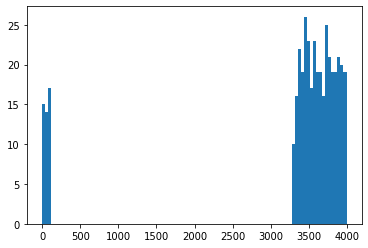

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys):
    # we observe that poisoning keys are densly populated together
    plt.hist(poisoning_keys, bins = 100, range=[0, df[0][len(df)-1]])
    plt.show()

plot_distribution_of_poisoning_keys(poisoning_keys)

In [34]:
X_poisoned = np.append(X, list(poisoning_keys))
y_poisoned = ss.rankdata(X_poisoned)

In [35]:
X_poisoned = X_poisoned.reshape(-1,1)
regressor_poisoned = LinearRegression()
regressor_poisoned.fit(X_poisoned, y_poisoned)  

y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

In [36]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)

------------------
Mean Squared Error: 5015.2233666297


In [37]:
ratio_loss =  mse_poisoned / mse_legitimate

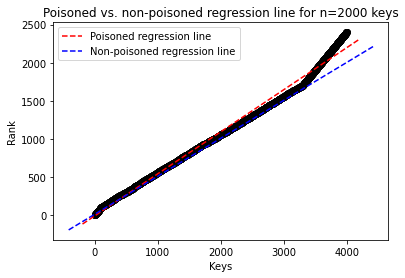

In [38]:
# Plot outputs
plt.scatter(X_poisoned, y_poisoned,  color='black')
abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
label= "Poisoned vs. non-poisoned regression line for n="+ str(X.shape[0]) + " keys"
plt.title(label=label)
plt.show()

## Linear regression experiments with different key sizes / different poisoning percentages

In [15]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

-------------------------
Dataset size:  500
Mean Squared Error: 10.816464904609312
Mean Squared Error: 11.11713079239834
Mean Squared Error: 12.038229273838143
Mean Squared Error: 13.815707106720806
Mean Squared Error: 17.88193188797914
Mean Squared Error: 24.44914795010329
Mean Squared Error: 29.810067013172063
Mean Squared Error: 40.357670960423974
Mean Squared Error: 53.644429094707164
Mean Squared Error: 66.05976278804661
Mean Squared Error: 84.0755512105039
Mean Squared Error: 105.08008239241076
Mean Squared Error: 128.41479806191754
Mean Squared Error: 148.75057197227716
Mean Squared Error: 169.84725277689816


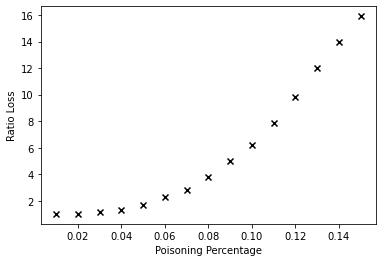

-------------------------
Dataset size:  1000
Mean Squared Error: 20.773564268523586
Mean Squared Error: 25.78819890323834
Mean Squared Error: 38.20042041745141
Mean Squared Error: 56.34731516231744
Mean Squared Error: 76.13307741398904
Mean Squared Error: 104.00910688645017
Mean Squared Error: 137.53844998726439
Mean Squared Error: 188.29765677644156
Mean Squared Error: 243.60929879108775
Mean Squared Error: 307.26563547759065
Mean Squared Error: 379.5819577658792
Mean Squared Error: 459.9276318940463
Mean Squared Error: 527.3773904911287
Mean Squared Error: 609.9754483106909
Mean Squared Error: 708.88213444713


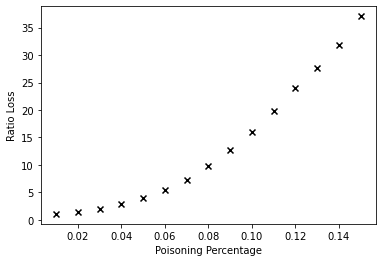

In [16]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = ss.rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()

## Algorithm 2 - Greedy poisoining RMI

The following code implements **Algorithm 2 (Greedy Poisoning RMI)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [10]:
from numpy import unravel_index

In [18]:
def compute_loss_rmi(X, y):
    
    regressor_poisoned = LinearRegression()
    regressor_poisoned.fit(X, y)

    y_pred = regressor_poisoned.predict(X)
    mse_poisoned = metrics.mean_squared_error(y, y_pred)
    #print('Mean Squared Error:', mse_poisoned) 
    return mse_poisoned


def compute_move_forward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI, N):


    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()
    keyset_per_model_dup = keyset_per_model.copy()


    for i in range(N-1):
    
        # (A) Add poisoning key to P_i+1
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i+1], list(poisoning_keys_per_model_dup[i+1]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        # set percentage such that we obtain exactly **one** additional poisoning key
        p = 1/X_poisoned.shape[0]


        # obtain **one** additional poisoning key
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i+1].update(poisoning_key)


        # (B) Move smallest legitimate key from (i+1)-th to i-th
        #
        #
        keyset_per_model_dup[i] = np.append(keyset_per_model_dup[i], keyset_per_model_dup[i+1][0])

        # delete smallest legitimate key
        keyset_per_model_dup[i+1] = np.delete(keyset_per_model_dup[i+1], 0)


        # (C) Remove poisoning key from P_i
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i].pop()

        # Store updated loss for every model after completing the key moves above
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute updated L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()
        changeloss[i, i+1] = L_RMI_changed - L_RMI

    return changeloss



def compute_move_backward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI, N):

    keyset_per_model_dup = keyset_per_model.copy()
    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()


    for i in range(N-1):

        # (A) Add poisoning key to P_i
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i], list(poisoning_keys_per_model_dup[i]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        # set percentage such that we obtain exactly **one** poisoning key
        p = 1/X_poisoned.shape[0]


        # obtain one additional poisoning key
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i].update(poisoning_key)


        # (B) Move smallest legitimate key from i-th to (i+1)-th
        #
        #
        keyset_per_model_dup[i+1] = np.append(keyset_per_model_dup[i+1], keyset_per_model_dup[i][-1])

        # delete largest legitimate key
        keyset_per_model_dup[i] = np.delete(keyset_per_model_dup[i], len(keyset_per_model_dup[i]) -1)


        # (C) Remove poosoning key from P_i+1
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i+1].pop()

        # Store updated loss for every model after completing the key moves above
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute updated L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()

        changeloss[i+1, i] = L_RMI_changed - L_RMI
    
    return changeloss

In [19]:
def update_changeloss(keyset_per_model, poisoning_keys_per_model, L_RMI, N):
    
    # Initialize changeloss
    changeloss = np.zeros(shape = (N, N))
    
    
    # Store effect of exchange i -> i+1 in changeloss 
    changeloss = compute_move_forward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI, N)
    
    # Store the effect of exchange i <- i+1 in Changeloss
    changeloss = compute_move_backward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI, N)
    
    return changeloss
    

In [20]:
def greedy_poisoning_regression_rmi(phi, X, N, epsilon, visualize = False):
    
    # smoothing constant alpha = {2, 3}
    alpha = 1

    # key set size 
    n = X.shape[0]

    # max. number of poisoning keys per model
    t = (alpha*phi*n) / N
    print("Max number of poisoning keys: " + str(t))

    # initial size of keysets prior to poisoning
    initial_size = n / N

    
    # keep track of poisoning keys
    num_poisoning_keys = {}
    for i in range(N):
        num_poisoning_keys[i] = 0
        
    # Calculate ranks 
    y = ss.rankdata(X)
    
    # Split keyset and rankset into N parts and obtain poisoned keys
    keyset_per_model = np.split(X, N)
    rankset_per_model = np.split(y, N)

    # Keep original keyset / rankset for further references
    keyset_per_model_orig = keyset_per_model.copy()
    rankset_per_model_orig = rankset_per_model.copy()

    poisoning_keys_per_model = {}
    loss_per_model = {}

    # Initial volume allocation
    # Iterate through all the regression models of the second-stage and for the i-th model, initialize P_i by injecting ϕ*n / N poisoning keys
    # using Algorithm 1
    for i in range(N):
        poisoning_keys_per_model[i] = obtain_poisoning_keys(p = phi, keyset = keyset_per_model[i], rankset = rankset_per_model[i])

        X_poisoned = np.append(keyset_per_model[i], list(poisoning_keys_per_model[i]))
        # calculate updated rank
        y_poisoned = ss.rankdata(X_poisoned)

        
        X_poisoned = X_poisoned.reshape(-1,1)
        # compute MSE loss for current second-stage model
        loss_per_model[i]  = compute_loss_rmi(X_poisoned, y_poisoned)

    # Compute baseline L_RMI by averaging the loss of second-sage models
    L_RMI = np.array(list(loss_per_model.values())).mean()
    
    # Update changeloss
    changeloss = update_changeloss(keyset_per_model, poisoning_keys_per_model, L_RMI, N)


    # Greedy iteration that increases the loss of the RMI
    while True:

        # Find indices (i, j) that correspond to largest entry in changeloss
        i, j = unravel_index(changeloss.argmax(), changeloss.shape)

        # print("Considering index: (" + str(i) + ", " + str(j) + ")")
            
        # If indices (i, j) violate the poisoning threshold t, we obtain the next largest item in changeloss
        # Note: we need at least one poisoning key to compute changeloss....
        while num_poisoning_keys[j] >= t-1 or len(poisoning_keys_per_model[i]) == 1:
            # if poisoning threshold for selected model j has been reached, we ignore changeloss value
            changeloss[i, j] = 0

            i, j = unravel_index(changeloss.argmax(), changeloss.shape)
            # print("Max. # of poisoning keys reached - using: (" + str(i) + ", " + str(j) + ")")
            
            if changeloss.argmax() < epsilon:
                break
    
        # if changeloss is below certain threshold or every model has reached max number of poisoning keys, we stop
        if changeloss.argmax() < epsilon or all(i > t for i in list(num_poisoning_keys.values())):
            print("Maximum changeloss below epsilon = " + str(epsilon))
            break
        

        #
        # Peform change i -> j between model i and j
        #

        # Move legitimate key from j-th to i-th
        #
        #
        if i < j:
            # take smallest element from model j
            keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][0])
            # delete smallest legitimate key
            #print("Moved legit key " + str(keyset_per_model[j][0]) + " from model " + str(j) + " to model " + str(i))
            keyset_per_model[j] = np.delete(keyset_per_model[j], 0)
        else: 
            # take largest element from model j
            keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][-1])
            # delete largest legitimate key
            #print("Moved legit key " + str(keyset_per_model[j][-1]) + " from model " + str(j) + " to model " + str(i))


            keyset_per_model[j] = np.delete(keyset_per_model[j], len(keyset_per_model[j])-1)

        # Remove poisoning key from P_i
        #
        #
        removed_poisoning_key = poisoning_keys_per_model[i].pop()
        #print("Removed poisoning key " + str(removed_poisoning_key) + " from model " + str(i))
        
        
        # Add new poisoning key to P_j - set percentage such that we obtain exactly **one** poisoning key
        total_X = np.append(keyset_per_model[j], list(poisoning_keys_per_model[j]))
        my_p = 1/total_X.shape[0]
        rankset = ss.rankdata(total_X)

        #print(poisoning_keys_per_model[j])
        new_poisoning_key =  obtain_poisoning_keys(p = my_p, keyset = total_X, rankset = rankset)
        poisoning_keys_per_model[j].update(new_poisoning_key)
        #print("Added additional poisoning key " + str(new_poisoning_key) + " to model " + str(j))


        #for i in range(N):
        #    print("Model " + str(i) +": # of legit keys: " + str(len(keyset_per_model[i])) + ", # of poisoned keys: " + str(len(poisoning_keys_per_model[i])))

        # Update changeloss values
        changeloss = update_changeloss(keyset_per_model, poisoning_keys_per_model, L_RMI, N)

        #print(changeloss)

        # Update number of poisoning keys for current model
        num_poisoning_keys[j] += 1
    
    
    # Visualize key distributions
    if visualize:
        for i in range(N):
            X_poisoned = np.append(keyset_per_model_orig[i], list(poisoning_keys_per_model[i]))
            print("Original keyset: ")
            print(keyset_per_model_orig[i].T)
            X_poisoned.sort()
            print("Poisoned keyset: ")
            print(X_poisoned)
            rankset_poisoned = ss.rankdata(X_poisoned)

            # For visualization purposes we shift the rank to match the original data
            rank_shift = i*(n/N)
            rankset_poisoned += rank_shift

            plt.scatter(X_poisoned, rankset_poisoned,  color='red', label="Original + poisoned keys")
            plt.scatter(keyset_per_model_orig[i], rankset_per_model_orig[i],  color='black', label="Original keys")
            plt.xlabel("Keys")
            plt.ylabel("Rank")
            plt.legend()
            plt.show()
        
    return poisoning_keys_per_model


Max number of poisoning keys: 10.0
Maximum changeloss below epsilon = 5
Original keyset: 
[[  2   4   6  14  16  18  19  20  21  22  24  25  26  27  28  30  31  32
   34  35  36  37  40  44  45  46  47  48  53  56  63  68  69  70  71  73
   74  76  79  81  84  85  87  88  90  93  94  95  97  98 100 101 102 103
  104 105 107 114 115 117 119 120 123 124 128 131 133 140 142 144 146 150
  151 152 156 157 158 160 164 168 169 170 171 174 175 176 179 181 182 188
  189 190 191 193 194 199 201 202 204 207]]
Poisoned keyset: 
[  2   4   6  14  16  18  19  20  21  22  24  25  26  27  28  30  31  32
  34  35  36  37  40  44  45  46  47  48  53  56  63  68  69  70  71  73
  74  76  79  81  84  85  87  88  90  93  94  95  97  98 100 101 102 103
 104 105 107 114 115 117 119 120 123 124 128 131 133 140 142 144 146 150
 151 152 156 157 158 160 164 168 169 170 171 174 175 176 179 181 182 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207]


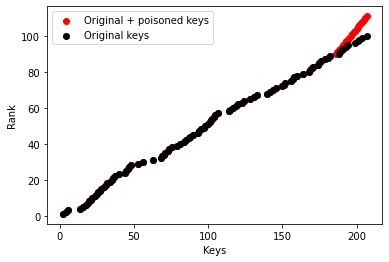

Original keyset: 
[[208 209 212 215 218 219 223 224 225 226 227 229 230 231 233 234 235 238
  239 241 243 244 246 247 250 251 252 253 255 256 257 258 259 264 265 266
  268 269 272 275 276 278 279 281 282 283 287 289 291 292 293 295 296 299
  303 304 313 314 315 316 317 318 321 322 323 325 327 328 332 334 336 337
  338 341 348 350 352 353 358 360 361 363 366 372 374 375 376 378 379 380
  383 384 387 388 390 391 392 395 396 397]]
Poisoned keyset: 
[208 209 212 215 218 219 223 224 225 226 227 229 230 231 233 234 235 238
 239 241 243 244 246 247 250 251 252 253 255 256 257 258 259 264 265 266
 268 269 272 275 276 278 279 281 282 283 287 289 291 292 293 295 296 299
 303 304 313 314 315 316 317 318 321 322 323 325 327 328 332 334 336 337
 338 341 343 344 345 346 347 348 349 350 351 352 353 354 355 358 360 361
 363 366 372 374 375 376 378 379 380 383 384 387 388 390 391 392 395 396
 397]


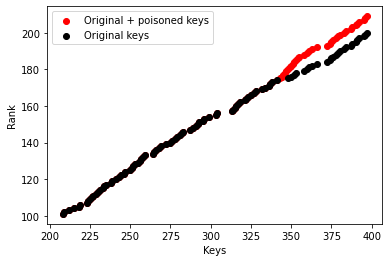

Original keyset: 
[[398 399 401 402 404 407 408 409 413 414 415 416 418 419 420 423 424 426
  427 428 429 434 436 437 439 441 442 444 445 447 448 449 450 451 452 453
  458 460 464 465 467 468 474 476 477 478 479 480 481 482 483 489 491 493
  495 496 497 499 500 501 502 504 505 506 508 510 512 513 514 515 519 528
  530 532 539 541 544 547 548 550 557 558 562 564 565 566 568 569 571 576
  578 579 582 585 587 589 590 600 602 605]]
Poisoned keyset: 
[398 399 401 402 404 407 408 409 413 414 415 416 418 419 420 423 424 426
 427 428 429 434 436 437 439 441 442 444 445 447 448 449 450 451 452 453
 458 460 464 465 467 468 474 476 477 478 479 480 481 482 483 489 491 493
 495 496 497 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 519 521 522 523 524 525 528 530 532 539 541 544 547 548 550
 557 558 562 564 565 566 568 569 571 576 578 579 582 585 587 589 590 600
 602 605]


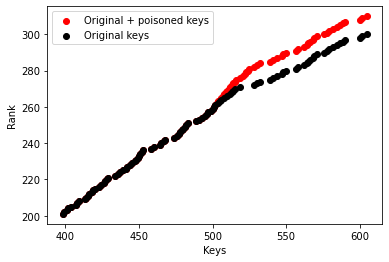

Original keyset: 
[[606 608 609 610 611 612 613 619 621 622 623 624 625 627 628 633 638 639
  640 641 643 647 650 651 652 653 657 658 659 663 668 670 671 673 675 676
  677 679 681 682 683 685 686 688 689 690 691 693 694 695 698 702 705 706
  709 712 713 714 716 717 719 720 721 727 729 733 736 737 738 740 741 742
  743 744 745 746 747 748 749 750 751 752 753 754 755 758 759 761 762 763
  764 765 766 768 769 770 772 773 774 775]]
Poisoned keyset: 
[606 608 609 610 611 612 613 619 621 622 623 624 625 627 628 633 638 639
 640 641 643 647 650 651 652 653 657 658 659 663 668 670 671 673 675 676
 677 679 681 682 683 685 686 688 689 690 691 693 694 695 698 702 705 706
 709 712 713 714 716 717 719 720 721 727 729 733 736 737 738 740 741 742
 743 744 745 746 747 748 749 750 751 752 753 754 755 756 758 759 761 762
 763 764 765 766 768 769 770 772 773 774 775]


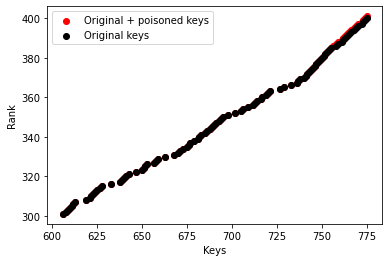

Original keyset: 
[[777 779 781 782 783 788 790 792 794 795 796 799 803 806 807 808 809 811
  813 814 816 817 818 820 823 828 833 835 838 843 846 847 850 856 863 864
  865 866 867 868 869 870 874 877 881 884 886 887 890 893 897 898 899 902
  904 905 907 908 910 911 912 913 914 916 917 921 922 925 935 938 940 941
  942 945 946 948 950 951 955 956 960 961 963 964 968 969 970 971 973 978
  979 980 981 982 983 984 987 992 995 996]]
Poisoned keyset: 
[767 777 779 781 782 783 788 790 792 794 795 796 799 803 806 807 808 809
 811 813 814 816 817 818 820 823 828 833 835 838 843 846 847 850 856 863
 864 865 866 867 868 869 870 871 874 877 881 884 886 887 890 893 896 897
 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915
 916 917 918 919 920 921 922 923 924 925 926 927 928 929 931 935 938 940
 941 942 945 946 948 950 951 955 956 960 961 963 964 968 969 970 971 973
 978 979 980 981 982 983 984 987 992 995 996]


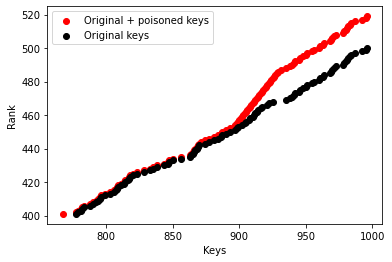

In [21]:
df=pd.read_csv('../data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
#y = np.array(df[1])

poisoning_keys = greedy_poisoning_regression_rmi(phi = 0.1, X = X, N = 5, epsilon = 5, visualize = True)
#print(poisoning_keys)

## Experiments with different key sizes / number of models

-------------------------
Dataset size:  500
Max number of poisoning keys: 5.0
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 7.500000000000002
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 10.0
Maximum changeloss below epsilon = 5


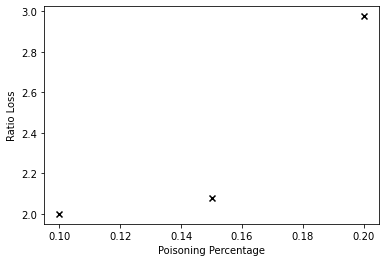

-------------------------
Dataset size:  1000
Max number of poisoning keys: 10.0
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 15.000000000000004
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 20.0
Maximum changeloss below epsilon = 5


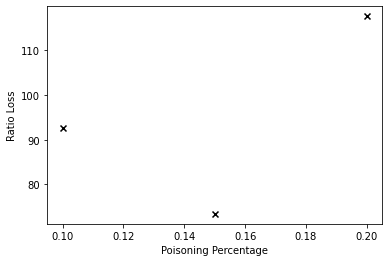

-------------------------
Dataset size:  2000
Max number of poisoning keys: 20.0
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 30.000000000000007
Maximum changeloss below epsilon = 5
Max number of poisoning keys: 40.0
Maximum changeloss below epsilon = 5


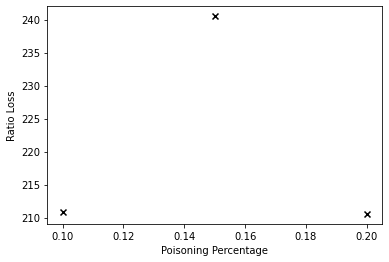

In [22]:
dataset_sizes = [500, 1000, 2000]

# number of second-stage models
N = 10

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)
    
    # Split keyset and rankset into N parts and obtain poisoned keys
    keyset_per_model = np.split(X, N)
    rankset_per_model = np.split(y, N)

    ratio_losses = []
    
    mse_legitimate_per_model = {}
    
    # Calculate MSE loss for legitimate (non-poisoned) keys
    #print("Legitimate loss: ")
    for i in range(N):
        mse_legitimate_per_model[i] = compute_loss_rmi(keyset_per_model[i], rankset_per_model[i])
        #print("Model " + i + ": " + mse_legitimate_per_model[i])
    mse_legitimate = np.array(list(mse_legitimate_per_model.values())).mean()

    poisoning_percentages = np.linspace(0.1, 0.2, num= 3)

    for percentage in poisoning_percentages:
        # Obtain poisoning keys for model
        poisoning_keys = greedy_poisoning_regression_rmi(phi=percentage, X = X, N = N, epsilon = 5, visualize = False)
        
        mse_poisoned_per_model = {}
        
        # Calculate MSE loss for poisoned model
        #print("Poisoned loss:")
        for i in range(N):
            X_poisoned = np.append(keyset_per_model[i], list(poisoning_keys[i]))
            X_poisoned = X_poisoned.reshape(-1, 1)
            
            #print(X_poisoned)
            rankset_poisoned = ss.rankdata(X_poisoned)
                        
            loss = compute_loss_rmi(X_poisoned, rankset_poisoned)
            #diff = loss - mse_legitimate_per_model[i]
            #print("Difference in model " + str(i) + ": " + str(diff))
            mse_poisoned_per_model[i] = loss
        mse_poisoned = np.array(list(mse_poisoned_per_model.values())).mean()
        
        # Calculate ratio loss over all second-stage RMI models
        ratio_loss =  mse_poisoned / mse_legitimate
        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()